In [1]:
#K-Nearest-Neighbors analysis
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score


In [2]:
df = pd.read_csv('../data/data_clean.csv')

for col in df.columns:
    print(col)

City
State
Bank
ApprovalFY
Term
NoEmp
CreateJob
RetainedJob
FranchiseCode
UrbanRural
RevLineCr
LowDoc
DisbursementGross
GrAppv
SBA_Appv
Default
NAICS_i
isNewBusiness
isFranchise
SBARatio
InterestRate


In [3]:
# one-hot encode UrbanRural and include it
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder(sparse_output=False,handle_unknown='ignore')

UR_encoded = OHE.fit_transform(df[['UrbanRural']])
UR_enc_df = pd.DataFrame(UR_encoded,columns = OHE.get_feature_names_out(['UrbanRural']))
df = pd.concat([df,UR_enc_df], axis=1)
df.drop(columns=['UrbanRural'], inplace=True)

In [4]:
# Look for and remove outliers

def remove_outliers(df:pd.DataFrame, c:str):
    z_scores = np.abs((df[c] - df[c].mean())/df[c].std())
    no_outliers = df[z_scores < 3]
    return no_outliers

#remove outliers from features

have_outliers = ['Term','NoEmp','CreateJob','RetainedJob','GrAppv','SBA_Appv','DisbursementGross']

for col in have_outliers:
    print(f"\n\nCol: {col}")
    print("\nBefore:")
    for s in df[col].describe().to_string().split('\n'):
        print(f'\t{s}')
    df = remove_outliers(df,col)
    print("\nAfter:")
    for s in df[col].describe().to_string().split('\n'):
        print(f'\t{s}')




Col: Term

Before:
	count    870514.000000
	mean        111.508946
	std          79.177488
	min           0.000000
	25%          60.000000
	50%          84.000000
	75%         120.000000
	max         569.000000

After:
	count    870352.000000
	mean        111.458809
	std          79.097905
	min           0.000000
	25%          60.000000
	50%          84.000000
	75%         120.000000
	max         349.000000


Col: NoEmp

Before:
	count    870352.000000
	mean         11.478524
	std          74.594736
	min           0.000000
	25%           2.000000
	50%           4.000000
	75%          10.000000
	max        9999.000000

After:
	count    868960.000000
	mean         10.020323
	std          17.337608
	min           0.000000
	25%           2.000000
	50%           4.000000
	75%          10.000000
	max         235.000000


Col: CreateJob

Before:
	count    868960.000000
	mean          8.526285
	std         239.181681
	min           0.000000
	25%           0.000000
	50%           0.000000
	75

In [5]:
# Select Features (X) and Target (Y)
#X = df[['ApprovalFY','Term','NoEmp','CreateJob','RetainedJob','FranchiseCode','UrbanRural','RevLineCr','LowDoc','GrAppv','SBA_Appv','NAICS_i','isNewBusiness','isFranchise','SBARatio','InterestRate']]
experimental_features = ['City', 'State', 'Bank', 'ApprovalFY', 'NAICS_i', 'FranchiseCode']
target = 'Default'
features = [f for f in df.columns if f not in experimental_features and f not in target]

X = df[features]
Y = df[target]

In [6]:
# Scale the test data
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
# X_train_scaled = sc.fit_transform(X_train)
# X_cv_scaled = sc.transform(X_cv)
# X_test_scaled = sc.transform(X_test)
# X_scaled = sc.transform(X)

X_scaled = sc.fit_transform(X)

In [7]:
# Do a train-test split
X_train, X_tmp, y_train, y_tmp = train_test_split(X_scaled,Y,test_size=0.2,random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_tmp, y_tmp, test_size=.5)



In [8]:
# initialize the model
knn = KNeighborsClassifier(n_neighbors=15, n_jobs=-1,)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=15)

In [9]:
# copied from logit
#coefficients = knn.coef_[0]

#coef_df = pd.DataFrame({'Feature':X.columns, 'Coefficient':coefficients})
#print(coef_df)

In [10]:
# make predictions
yhat_train = knn.predict(X_train)
yhat_cv = knn.predict(X_test)

#import scoring_utils

#score = pd.concat([
#    scoring_utils.get_metrics(y_train,yhat_train, "KNN Train"),
#    scoring_utils.get_metrics(y_test,yhat_cv, "KNN CV")
#])

#score

In [11]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': -1,
 'n_neighbors': 15,
 'p': 2,
 'weights': 'uniform'}

In [35]:
yhat_total = knn.predict(X_scaled)

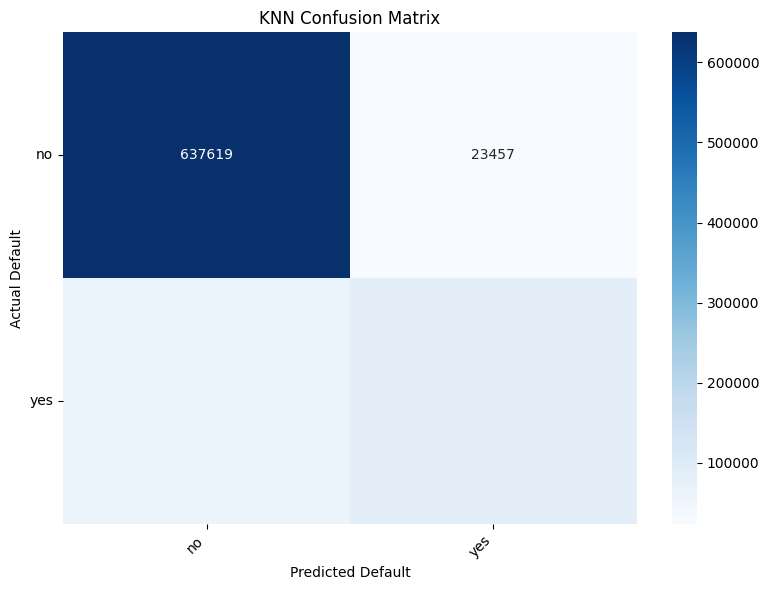

In [34]:
import scoring_utils
from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve, auc, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


#scoring_utils.get_confusion_matrix(Y, yhat_total, "KNN")
y_true = Y
y_pred = yhat_total
cm = confusion_matrix(y_true, y_pred)



# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.xlabel('Predicted Default')
plt.ylabel('Actual Default')
plt.title(f'{"KNN"} Confusion Matrix')
plt.xticks(rotation=45, ha="right")  # Adjust x-axis label positions
plt.yticks(rotation=0, va="center")  # Adjust y-axis label positions
plt.tight_layout()  # Adjust the layout
plt.show()

In [31]:
cm

array([[637619,  23457],
       [ 57186,  86489]])

In [36]:
recall_score(y_true,y_pred)

0.6019766834870367

In [37]:
accuracy_score(y_true,y_pred)

0.8997913640368262

In [15]:
precision_score(y_true,y_pred)

(804751, 16)

In [16]:
X.columns

Index(['Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'RevLineCr', 'LowDoc',
       'DisbursementGross', 'GrAppv', 'SBA_Appv', 'isNewBusiness',
       'isFranchise', 'SBARatio', 'InterestRate', 'UrbanRural_0',
       'UrbanRural_1', 'UrbanRural_2'],
      dtype='object')

In [17]:
scoring_utils.get_profit(X,Y,yhat_total)

3549621485.5500007